# 딥러닝 모델을 학습시키기 위해 준비되어야 할 4가지 요소

**1. 데이터**
2. 모델
3. Loss function (손실함수, 목적함수, objective function 등으로 불려요): 정답과 모델의 예측값을 어떤 식으로 비교할지 결정해주는 함수
4. optimizer: gradient descent를 해줄 애. 즉, 모델의 파라미터를 어느 방향으로 조금 수정할지 결정하고 수정해주는 함수

# Part 1 : Data Loader

In [3]:
import numpy as np
import os, sys
import tarfile
import matplotlib.pyplot as plt

from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from tqdm import tqdm

# Config the matplotlib backend as plotting inline in Ipython
%matplotlib inline

## 데이터 다운로드 하기

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'

data_root = './data'
if not os.path.exists(data_root):
    os.mkdir(data_root)
    
def dataset_downloader(filename):
    """데이터셋 파일이 없으면 다운로드 합니다."""
    dest_dir = os.path.join(data_root, filename)
    if not os.path.exists(dest_dir):
        print('다운로드 시도 중 : ', filename)
        filename, _ = urlretrieve(url + filename, dest_dir)
        print(filename, ' 다운로드 완료!')
    else:
        print(dest_dir, ' 이미 있습니다.')
    
    return dest_dir

train_filename = dataset_downloader('notMNIST_large.tar.gz')
test_filename = dataset_downloader('notMNIST_small.tar.gz')

다운로드 시도 중 :  notMNIST_large.tar.gz
./data/notMNIST_large.tar.gz  다운로드 완료!
다운로드 시도 중 :  notMNIST_small.tar.gz
./data/notMNIST_small.tar.gz  다운로드 완료!


## 다운로드한 데이터 압축 풀기

In [5]:
num_classes = 10
np.random.seed(1000)

def data_extract(filename):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    
    if os.path.isdir(root):
        print('{} 이미 있습니다 - {} 는 추출을 건너뜁니다.'.format(root, filename))
    else:
        print('{} 에서 데이터를 추출합니다.'.format(root))
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    
    if len(data_folders) != num_classes:
        raise Exception('{} folders 기대했는데, {} 개가 있네요.'.format(num_classes, len(data_folders)))
    
    print(data_folders)
    return data_folders

train_folders = data_extract(train_filename)
test_folders = data_extract(test_filename)

./data/notMNIST_large 에서 데이터를 추출합니다.
['./data/notMNIST_large/A', './data/notMNIST_large/B', './data/notMNIST_large/C', './data/notMNIST_large/D', './data/notMNIST_large/E', './data/notMNIST_large/F', './data/notMNIST_large/G', './data/notMNIST_large/H', './data/notMNIST_large/I', './data/notMNIST_large/J']
./data/notMNIST_small 에서 데이터를 추출합니다.
['./data/notMNIST_small/A', './data/notMNIST_small/B', './data/notMNIST_small/C', './data/notMNIST_small/D', './data/notMNIST_small/E', './data/notMNIST_small/F', './data/notMNIST_small/G', './data/notMNIST_small/H', './data/notMNIST_small/I', './data/notMNIST_small/J']


## 각 글자 데이터를 로드해서 pickle 파일 형태로 저장하기

주의: 오래 걸립니다

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder):
    """한 글자 클래스 데이터를 로드합니다."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth  # image 픽셀값의 범위를 -0.5 ~ 0.5로 만들어줍니다.
            if image_data.shape != (image_size, image_size):
                raise Exception('이미지가 이상한 크기인데요?: {}'.format(str(image_data.shape)))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('{} - skip'.format(e))
    
    dataset = dataset[0:num_images, :, :]
    print('전체 데이터셋 모양은 다음과 같습니다:', dataset.shape)
    
    return dataset
        
def make_pickle(data_folders):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename):
            print('{} 이미 있습니다 - pickling을 건너뜁니다.'.format(set_filename))
            continue
        print('Pickling {}'.format(set_filename))
        dataset = load_letter(folder)
        with open(set_filename, 'wb') as f:
            pickle.dump(dataset, f)

    return dataset_names

train_datasets = make_pickle(train_folders)
test_datasets = make_pickle(test_folders)

Pickling ./data/notMNIST_large/A.pickle


/home/zendo/anaconda3/envs/iab/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


cannot identify image file './data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - skip
cannot identify image file './data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - skip
cannot identify image file './data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - skip
전체 데이터셋 모양은 다음과 같습니다: (52909, 28, 28)
Pickling ./data/notMNIST_large/B.pickle
cannot identify image file './data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - skip
전체 데이터셋 모양은 다음과 같습니다: (52911, 28, 28)
Pickling ./data/notMNIST_large/C.pickle
전체 데이터셋 모양은 다음과 같습니다: (52912, 28, 28)
Pickling ./data/notMNIST_large/D.pickle
cannot identify image file './data/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - skip
전체 데이터셋 모양은 다음과 같습니다: (52911, 28, 28)
Pickling ./data/notMNIST_large/E.pickle
전체 데이터셋 모양은 다음과 같습니다: (52912, 28, 28)
Pickling ./data/notMNIST_large/F.pickle
전체 데이터셋 모양은 다음과 같습니다: (52912, 28, 28)
Pickling ./data/notMNIST_large/G.pickle
전체 데이터셋 모양은 다음과 같습니다: (52912, 28, 28)
Pickling ./data/n

## 이미지 예시 보기

100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


(10, 28, 28)


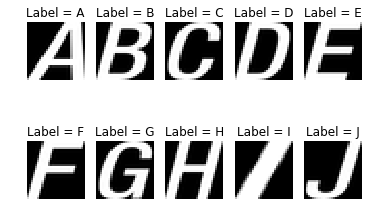

In [7]:
images = []
for i in tqdm(range(len(train_datasets))):
    set_filename = train_datasets[i]
    with open(set_filename, 'rb') as f:
        dataset = pickle.load(f)
    images.append(dataset[1])
print(np.shape(images))

Row = 2
Column = 5
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('Label = {}'.format(os.path.basename(train_datasets[i])[0]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

## 트레이닝셋, 테스트셋 개수 확인

In [8]:
print("==== 트레이닝셋을 위한 데이터들 ====")
for i in range(len(train_datasets)):
    set_filename = train_datasets[i]
    with open(set_filename, 'rb') as f:
        dataset = pickle.load(f)
    print("글자 {} 에 대한 트레이닝 데이터 개수는 {} 개입니다.".format(os.path.basename(set_filename)[0], len(dataset)))

print("\n==== 테스트셋을 위한 데이터들 =====")
for i in range(len(test_datasets)):
    set_filename = test_datasets[i]
    with open(set_filename, 'rb') as f:
        dataset = pickle.load(f)
    print("글자 {} 에 대한 테스트 데이터 개수는 {} 개입니다.".format(os.path.basename(set_filename)[0], len(dataset)))

==== 트레이닝셋을 위한 데이터들 ====
글자 A 에 대한 트레이닝 데이터 개수는 52909 개입니다.
글자 B 에 대한 트레이닝 데이터 개수는 52911 개입니다.
글자 C 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 D 에 대한 트레이닝 데이터 개수는 52911 개입니다.
글자 E 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 F 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 G 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 H 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 I 에 대한 트레이닝 데이터 개수는 52912 개입니다.
글자 J 에 대한 트레이닝 데이터 개수는 52911 개입니다.

==== 테스트셋을 위한 데이터들 =====
글자 A 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 B 에 대한 테스트 데이터 개수는 1873 개입니다.
글자 C 에 대한 테스트 데이터 개수는 1873 개입니다.
글자 D 에 대한 테스트 데이터 개수는 1873 개입니다.
글자 E 에 대한 테스트 데이터 개수는 1873 개입니다.
글자 F 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 G 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 H 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 I 에 대한 테스트 데이터 개수는 1872 개입니다.
글자 J 에 대한 테스트 데이터 개수는 1872 개입니다.


## 각 글자 별로 나뉘어져있던 데이터를 합쳐서 트레이닝셋, 테스트셋 2개로 만들기

In [9]:
def merge_datasets(pickle_files, dataset_size):
    num_classes = len(pickle_files)
    dataset = np.ndarray((dataset_size, image_size, image_size), dtype=np.float32)
    labels = np.ndarray(dataset_size, dtype=np.int32)
    tsize_per_class = dataset_size // num_classes

    start_t = 0
    end_t = tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        with open(pickle_file, 'rb') as f:
            letter_set = pickle.load(f)
            np.random.shuffle(letter_set)

            letter = letter_set[0:tsize_per_class, :, :]
            dataset[start_t:end_t, :, :] = letter
            labels[start_t:end_t] = label
            start_t += tsize_per_class
            end_t += tsize_per_class

    return dataset, labels

train_size = 200000
test_size = 10000

train_dataset, train_labels = merge_datasets(train_datasets, train_size)
test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Testing: (10000, 28, 28) (10000,)


### 데이터 섞어주기

In [10]:
def shuffle(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = shuffle(train_dataset, train_labels)
test_dataset, test_labels = shuffle(test_dataset, test_labels)

### 섞은 후에 다시 한 번 보기

==== 트레이닝 데이터 예시 ====


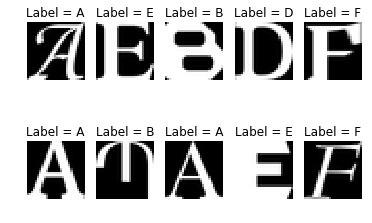

==== 테스트 데이터 예시 ====


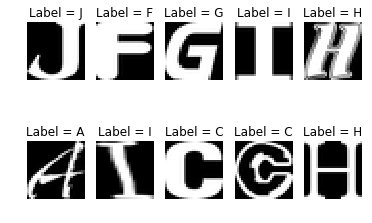

In [11]:
Row = 2
Column = 5
ListOfLabel = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

print("==== 트레이닝 데이터 예시 ====")
images = train_dataset[0:10]
labels = train_labels[0:10]
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('Label = {}'.format(ListOfLabel[labels[i]]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

print("==== 테스트 데이터 예시 ====")
images = test_dataset[0:10]
labels = test_labels[0:10]
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('Label = {}'.format(ListOfLabel[labels[i]]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

## 파일로 내보내기

In [12]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

f = open(pickle_file, 'wb')
save = {
    'train_dataset': train_dataset[:50000,],
    'train_labels': train_labels[:50000,],
    'test_dataset': test_dataset[:5000,],
    'test_labels': test_labels[:5000,],
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()